In [22]:
from glob import glob
import numpy as np
import statsmodels.api as sm
import pandas as pd
from os.path import dirname,basename

# Set study variables
analysis_home = '/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc'
output_dir = analysis_home + '/proc/network_analysis'
eyetracking_file = '/data/perlman/moochie/user_data/CamachoCat/ChEC/summarized_eyetracking_20200901.csv'
subject_info = pd.read_csv(analysis_home + '/misc/subjectinfo.csv', index_col=None)
subject_info = subject_info[subject_info['usable.25']==1]
subjects_list = subject_info['SubjID'].tolist()
template_atlas = analysis_home + '/template/MMP_subcort_warped.nii.gz'
template_atlas_key = analysis_home + '/template/MMP_subcort.csv'

In [21]:
# create CSV with subject-level network data
subject_beta_mats=glob(output_dir +'/correlation_matrix/*/correlation_matrix.csv')
subject_beta_mats = sorted(subject_beta_mats)

labels_df = pd.read_csv(template_atlas_key, index_col=None)
labels_df = labels_df.sort_values(by=['network_num'])
final_comms = labels_df.loc[:,['network_num','region_name']]

colnames = []
i=1
for a in range(1,8):
    for b in range(i,8):
        colnames.append('net{0}_net{1}'.format(a,b))
    i=i+1
sub_data = pd.DataFrame(columns=colnames,index=subjects_list)

for sub in subject_beta_mats:
    subID = int(basename(dirname(sub)))
    t = pd.read_csv(sub, index_col=0)
    t = t.reindex(labels_df['region_name'].tolist(),columns=labels_df['region_name'].tolist())
    t.columns = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    t.index = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    t[t==1]= np.nan
    t = t.groupby(level=0).mean()
    t = t.groupby(level=0, axis=1).mean()
    t = t.drop(labels=[0], axis=0)
    t = t.drop(labels=[0], axis=1)
    i = 1
    for a in range(1,8):
        for b in range(i,8):
            sub_data.loc[subID,'net{0}_net{1}'.format(a,b)] = t.loc[a,b]
        i=i+1
sub_data.index.name = 'ID'
sub_data.to_csv(output_dir + '/overall_conn_20201101.csv')

In [44]:
# combine connectivity and eye-tracking data into one file

eyetrack = pd.read_csv(eyetracking_file, index_col=0)
eyetrack.index.name='ID'
data = sub_data.merge(eyetrack, on='ID')
data.columns

Index(['net1_net1', 'net1_net2', 'net1_net3', 'net1_net4', 'net1_net5',
       'net1_net6', 'net1_net7', 'net2_net2', 'net2_net3', 'net2_net4',
       ...
       'Sad_Face_sadface_entrytime', 'Sad_Face_sadface_fixations',
       'Sad_Jumble_nonface_rawdwell', 'Sad_Jumble_nonface_firstfix',
       'Sad_Jumble_nonface_entrytime', 'Sad_Jumble_nonface_fixations',
       'Sad_Jumble_sadface_rawdwell', 'Sad_Jumble_sadface_firstfix',
       'Sad_Jumble_sadface_entrytime', 'Sad_Jumble_sadface_fixations'],
      dtype='object', length=148)

In [60]:
from scipy.stats import spearmanr

emotions = ['Angry','Sad','Fear']
pres = 'Jumble'
aoi = 'face'
meas = ['firstfix','entrytime']

for e in emotions:
    print('#################  {0}  #################'.format(e))
    for m in meas:
        r, p = spearmanr(data['net4_net5'],data['{0}_{1}_{2}_{3}'.format(e,pres,e.lower()+aoi,m)])
        if p < 0.05:
            pflag = '*'
        else:
            pflag=''
        print('{0}: r={1}, p={2}{3}'.format(m,round(r,2),round(p,3),pflag))
        

pres = 'Face'
aoi = ['eye','mouth']

for e in emotions:
    print('#################  {0}  #################'.format(e))
    for m in meas:
        for a in aoi:
            r, p = spearmanr(data['net4_net5'],data['{0}_{1}_{2}_{3}'.format(e,pres,a,m)],nan_policy='omit')
            if p < 0.05:
                pflag = '*'
            else:
                pflag=''
            print('{0} {1}: r={2}, p={3}{4}'.format(a,m,round(r,2),round(p,3),pflag))

#################  Angry  #################
firstfix: r=-0.13, p=0.465
entrytime: r=-0.35, p=0.044*
#################  Sad  #################
firstfix: r=0.22, p=0.221
entrytime: r=0.15, p=0.41
#################  Fear  #################
firstfix: r=-0.17, p=0.348
entrytime: r=-0.1, p=0.569
#################  Angry  #################
eye firstfix: r=0.13, p=0.453
mouth firstfix: r=0.08, p=0.666
eye entrytime: r=0.11, p=0.549
mouth entrytime: r=-0.01, p=0.971
#################  Sad  #################
eye firstfix: r=0.35, p=0.046*
mouth firstfix: r=0.12, p=0.522
eye entrytime: r=0.23, p=0.192
mouth entrytime: r=0.11, p=0.585
#################  Fear  #################
eye firstfix: r=0.11, p=0.53
mouth firstfix: r=0.17, p=0.33
eye entrytime: r=0.0, p=0.98
mouth entrytime: r=-0.11, p=0.576


In [66]:
subject_info.index = subject_info['SubjID']
subject_info.index.name='ID'
fulldata = data.merge(subject_info, on='ID')
r, p = spearmanr(fulldata['Angry_Jumble_angryface_entrytime'],fulldata['age_cent'],nan_policy='omit')
print(r)
print(p)

-0.1657754010695187
0.3487700833124503


<Figure size 432x360 with 0 Axes>

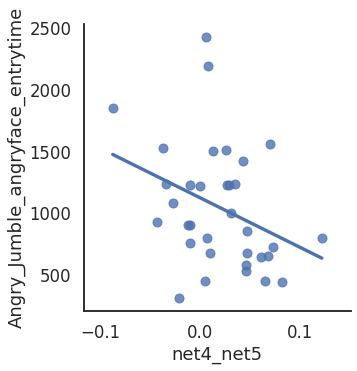

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

data = data.astype(float)
sns.set(context='talk', style='white')
plt.figure(figsize=(6,5))
sns.lmplot(x='net4_net5',y='Angry_Jumble_angryface_entrytime',data=data, ci=None)
plt.savefig('jumble_conn.svg')
plt.show()